# 特征工程

1. 异常值分析

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # 统计
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data_file = '../zhengqi_train.txt' # ./代表当前目录
test_data_file = '../zhengqi_test.txt'
train_data = pd.read_csv(train_data_file, sep='\t', encoding='utf-8') # 分隔符为'\t'
test_data = pd.read_csv(test_data_file, sep='\t', encoding='utf-8')


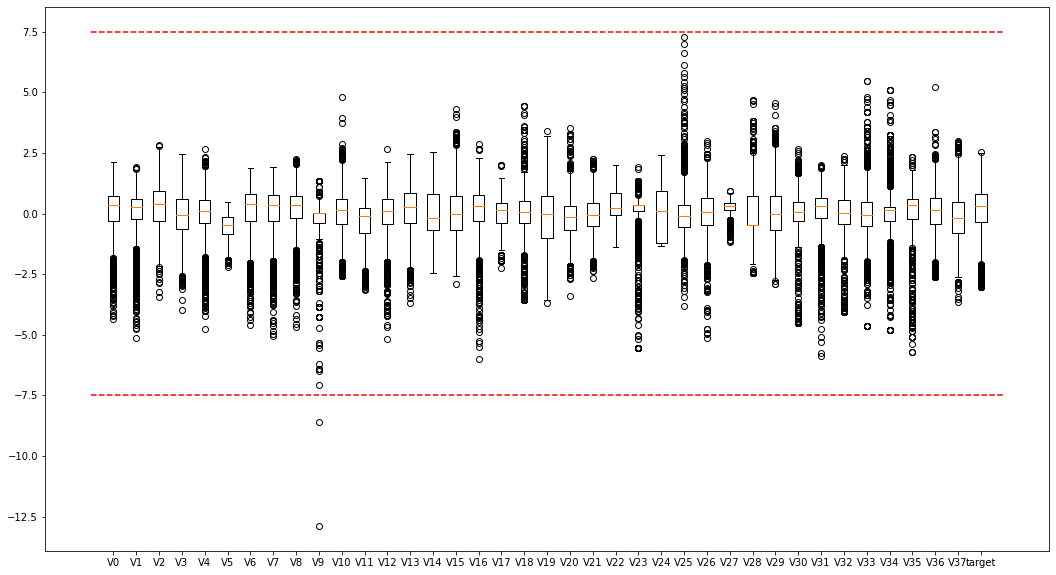

In [5]:
# 绘制箱线图
plt.figure(figsize=(18, 10))
plt.boxplot(x=train_data.values, labels=train_data.columns)
plt.hlines([-7.5, 7.5], xmin=0, xmax=40,linestyles='dashed', colors='r')
plt.show()


In [6]:
# 如V9是异常值，分别将训练集和测试集中的异常值删除
train_data = train_data[train_data['V9'] > -7.5] # 2888行变成2886行 删除了俩异常值
test_data = test_data[test_data['V9'] > -7.5] # 1925行不变
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 0 to 2887
Data columns (total 39 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0      2886 non-null   float64
 1   V1      2886 non-null   float64
 2   V2      2886 non-null   float64
 3   V3      2886 non-null   float64
 4   V4      2886 non-null   float64
 5   V5      2886 non-null   float64
 6   V6      2886 non-null   float64
 7   V7      2886 non-null   float64
 8   V8      2886 non-null   float64
 9   V9      2886 non-null   float64
 10  V10     2886 non-null   float64
 11  V11     2886 non-null   float64
 12  V12     2886 non-null   float64
 13  V13     2886 non-null   float64
 14  V14     2886 non-null   float64
 15  V15     2886 non-null   float64
 16  V16     2886 non-null   float64
 17  V17     2886 non-null   float64
 18  V18     2886 non-null   float64
 19  V19     2886 non-null   float64
 20  V20     2886 non-null   float64
 21  V21     2886 non-null   float64
 22  

2. 最大值和最小值的归一化

In [9]:
from sklearn import preprocessing 
# feature_columns = [col for col in train_data.columns if col not in ['target']]
feature_columns = train_data.columns.tolist()[:-1]
# 归一化(不对target进行归一化)
min_max_scaler = preprocessing.MinMaxScaler()  # 创建对象
train_data_scaler = min_max_scaler.fit_transform(train_data[feature_columns]) # 只对train集进行fit
test_data_scaler = min_max_scaler.transform(test_data) # 对test集只进行transform
train_data_scaler = pd.DataFrame(train_data_scaler) # ndarray -> df
train_data_scaler.columns = feature_columns # add columns
train_data_scaler['target'] = train_data['target'] # add 'target'

test_data_scaler = pd.DataFrame(test_data_scaler)
test_data_scaler.columns = feature_columns

# display(train_data_scaler.describe())
# display(test_data_scaler.describe())

3. 查看数据分布

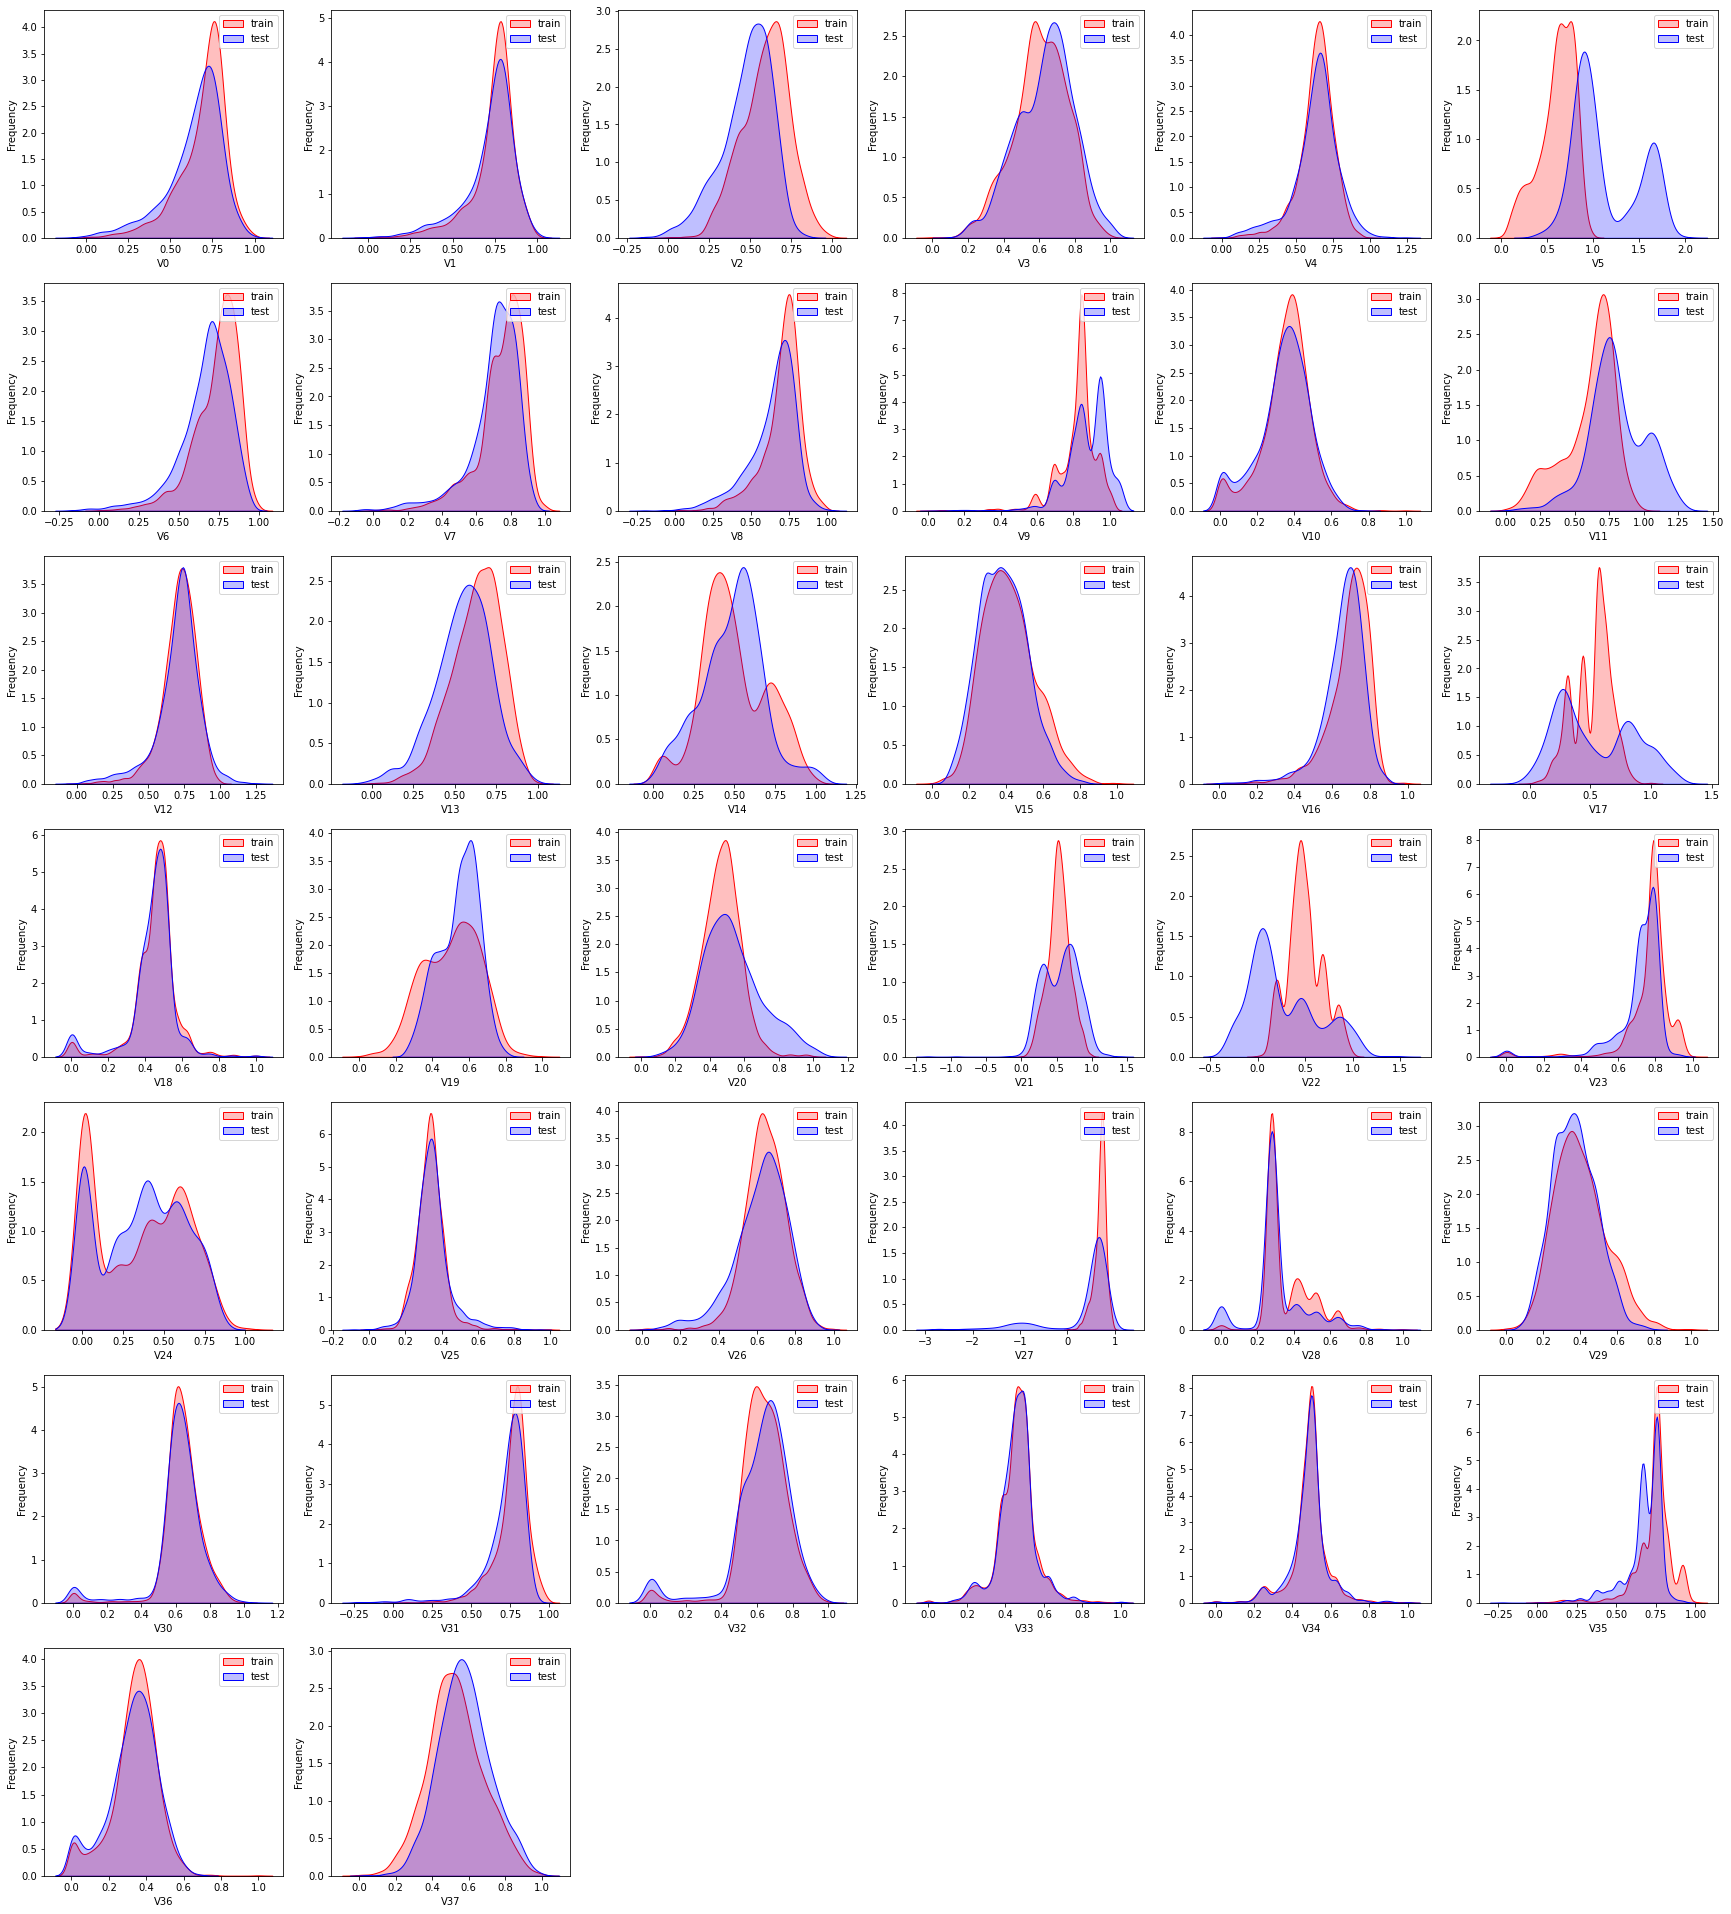

In [10]:
# 前文我们知道 v5,v9,v11,v17,v22,v28特征下模型测试集和训练集分布不一致，需要删除此类特征
drop_col = 6
drop_row = len(test_data_scaler.columns)
plt.figure(figsize=(5*drop_col, 5*drop_row))
for i, col in enumerate(test_data_scaler.columns):
    plt.subplot(drop_row, drop_col,i+1)
    sns.kdeplot(train_data_scaler[col], color='r', shade=True)
    sns.kdeplot(test_data_scaler[col], color='b', shade=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend(['train', 'test'])

4. 特征相关性

<AxesSubplot:>

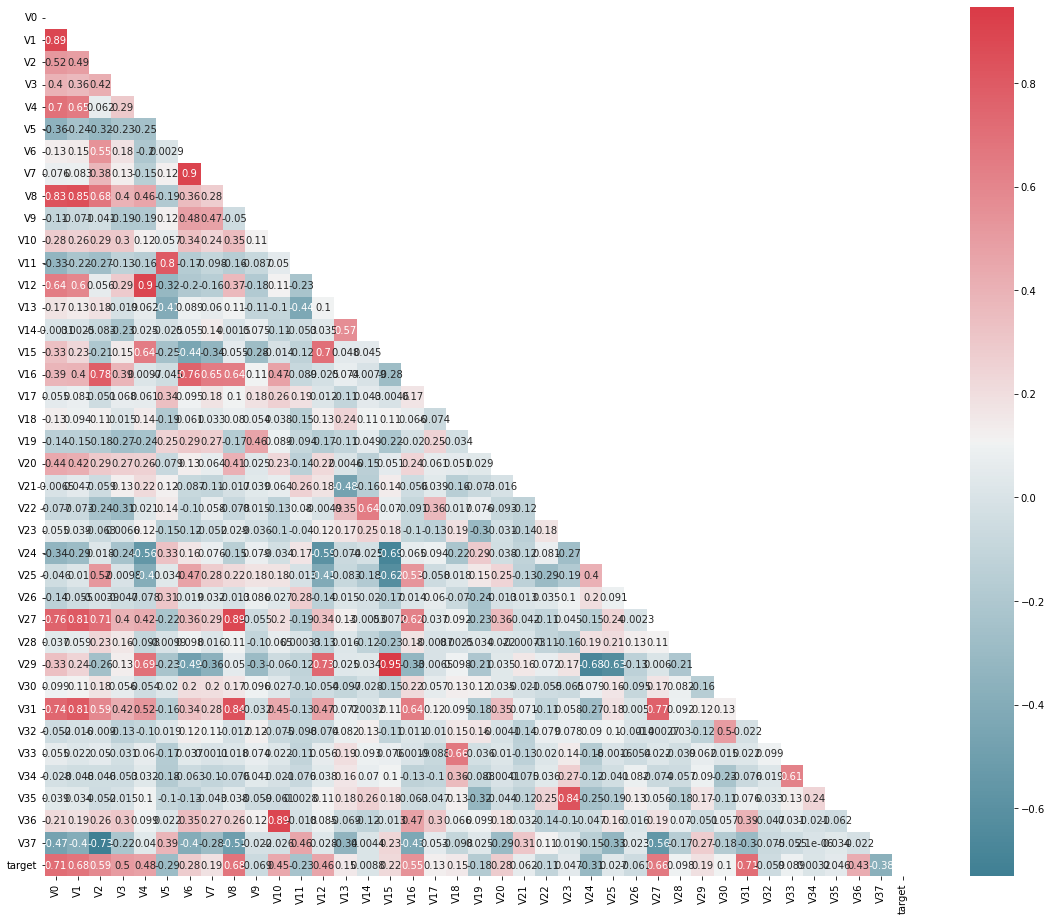

In [11]:
plt.figure(figsize=(20,16))
column = train_data_scaler.columns.tolist()
mcorr = train_data_scaler[column].corr(method='spearman')
# mcorr = train_data_scaler.corr(method="spearman") # 利用spearman计算相关性系数
mask = np.zeros_like(mcorr, dtype=bool) # 39*39 个False; ndarray
mask[np.triu_indices_from(mask)] = True # 将上三角设为True
# np.triu_indices_from(mask) 返回mask矩阵的上三角矩阵的各元素下标， tuple形式，len=2

cmap = sns.diverging_palette(220,10,as_cmap=True) # color map
sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True) # 将True的地方遮罩起来

5. 特征降维

In [12]:
# 进行特征相关性的初筛，计算相关性系数并筛选大于0.1的特征变量
mcorr = mcorr.abs()
numerical_corr = mcorr[mcorr['target'] > 0.1]['target']
numerical_corr
print(numerical_corr.sort_values(ascending=False)) # 降序排列

target    1.000000
V0        0.712403
V31       0.711636
V1        0.682909
V8        0.679469
V27       0.657398
V2        0.585850
V16       0.545793
V3        0.501622
V4        0.478683
V12       0.460300
V10       0.448682
V36       0.425991
V37       0.376443
V24       0.305526
V5        0.286076
V6        0.280195
V20       0.278381
V11       0.234551
V15       0.221290
V29       0.190109
V7        0.185321
V19       0.180111
V18       0.149741
V13       0.149199
V17       0.126262
V22       0.112743
V30       0.101378
Name: target, dtype: float64


6. 多重共线性分析

In [13]:
# 多重共线性分析
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 多重共线性 方差膨胀因子
new_numerical = ['V0', 'V2', 'V3', 'V4', 'V5', 'V6', 'V10', 'V11', 'V13',
                 'V15', 'V16', 'V18', 'V19', 'V20', 'V22', 'V24', 'V30', 'V31', 'V37']
# 该矩阵自行根据相关性矩阵看出并过滤筛选
X = np.matrix(train_data_scaler[new_numerical])
VIF_list = [variance_inflation_factor(X,i) for i in range(X.shape[1])] # range(19)
VIF_list

[216.73387180903222,
 114.38118723828812,
 27.863778129686356,
 201.96436579080174,
 78.93722825798903,
 151.06983667656212,
 14.519604941508451,
 82.69750284665385,
 28.479378440614585,
 27.759176471505945,
 526.6483470743831,
 23.50166642638334,
 19.920315849901424,
 24.640481765008683,
 11.816055964845381,
 4.958208708452915,
 37.09877416736591,
 298.26442986612767,
 47.854002539887034]

7. PCA处理

In [14]:
# PCA可去除数据的多重共线性，并进行降维；

# PCA将38个特征，降维成了21个主成分
from sklearn.decomposition import PCA # 主成分分析法

# 保留95%的信息
pca = PCA(n_components=0.95)
new_train_pca_95 = pca.fit_transform(train_data_scaler.iloc[:,:-1])
new_test_pca_95 = pca.transform(test_data_scaler)

new_train_pca_95 = pd.DataFrame(new_train_pca_95)
new_test_pca_95 = pd.DataFrame(new_test_pca_95)
new_train_pca_95['target'] = train_data_scaler['target']
# display(new_train_pca_95.describe())


In [16]:
# PCA保留16个主成分(与上述方法等效吧)
pca = PCA(n_components=16)
new_train_pca_16 = pca.fit_transform(train_data_scaler.iloc[:,:-1])
new_test_pca_16 = pca.transform(test_data_scaler)

new_train_pca_16 = pd.DataFrame(new_train_pca_16)
new_test_pca_16 = pd.DataFrame(new_test_pca_16)

new_train_pca_16['target'] = train_data_scaler['target']


1. 线性回归模型

1.1 PCA取特征->分割训练集

In [35]:
"""
new_train_pca_16: PCA处理后只剩下16个特征的训练集 (2886, 17)
new_test_pca_16: PCA处理后只剩下16个特征的测试集  (1925, 16)
train: 即X，没有target (2886, 16)
target: 即y (2886, )
"""
# display(new_test_pca_16.columns)
# display(new_train_pca_16[new_test_pca_16.columns])

from sklearn.model_selection import train_test_split
# display(new_train_pca_16.info()) # 为何target少2个值？
new_train_pca_16 = new_train_pca_16.fillna(0)  # 缺失值填充为0；采用PCA保留16维特征的数据
train = new_train_pca_16[new_test_pca_16.columns] # train 就是X，没有target (2886, 16)
target = new_train_pca_16['target']  # (2886, )

# display(train_data.shape) # (2886, 39)
# display(test_data.shape)  # (1925, 38)
# 切分训练集 训练数据80%，验证数据20%； 测试集始终没动
train_data, test_data, train_target, test_target = train_test_split(
    train, target, test_size=0.2, random_state=0) # 那原来的train_data和test_data变量怎么办
# display(train_data.shape) # (2308, 17) # 特征改为17个
# display(test_data.shape)  # (578, 17) # 此处test属于原训练集

In [36]:
from sklearn.metrics import mean_squared_error # 评价指标
from sklearn.linear_model import LinearRegression # 导入线性回归模型
clf = LinearRegression()
clf.fit(train_data,train_target)
test_pred = clf.predict(test_data)

score = mean_squared_error(test_target, clf.predict(test_data)) # MSE
print('LinearRegression:  ', score)

LinearRegression:   0.2716989246818662
